# Introduction

##### Should contain brief project, team, and task overview (how is project different to task?)

# Task 3: EDA 

##### Introduction to task.
##### Domain knowledge and overview of data
##### Ethical Considerations

#### The code below will take you through our initial data analysis and how we selected what preprocessing needed to be done before we performed gradient boosted tree regression. 

In [3]:
# Libraries and modules we will need for all 3 Tasks are listed here
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
# All sklearn functions below are for part 1 and 3, they are not used in part 2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Initial Data Analysis: Nulls, Distributions, etc

In [4]:
#Upload data in dataframe
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv('housing.csv', sep = '\s+', header = None, names = column_names)
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [5]:
# Check data for nulls, correct data types, etc
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


### Feature Selection: Correlation Heatmap, Outlier Analysis 

#### Correlation Map:

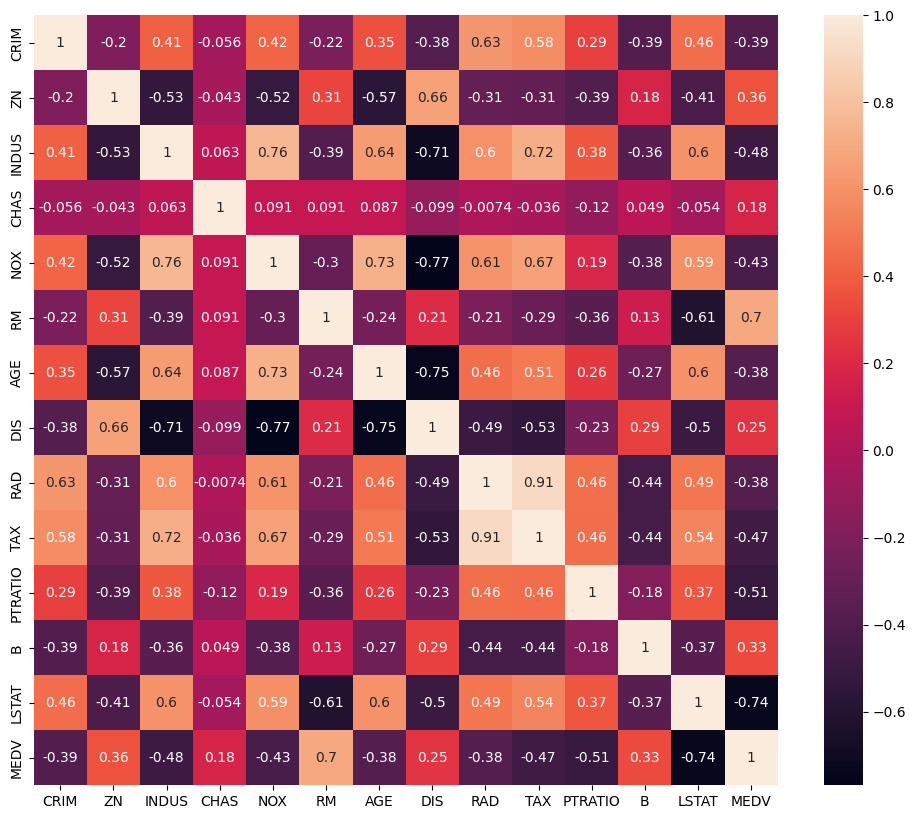

In [6]:
df_corr = df.corr()
fig, ax = plt.subplots(figsize= (12,10))
g = sns.heatmap(df_corr, annot=True, ax=ax)
plt.show()


#### Conclusions: 

##### - MEDV has a strong correlation with...
##### - But we can see that *list features here* are strongly correlated, so we only need to use...
##### - Any other things we get from this figure

### Outliers Analysis: 

#### Identification

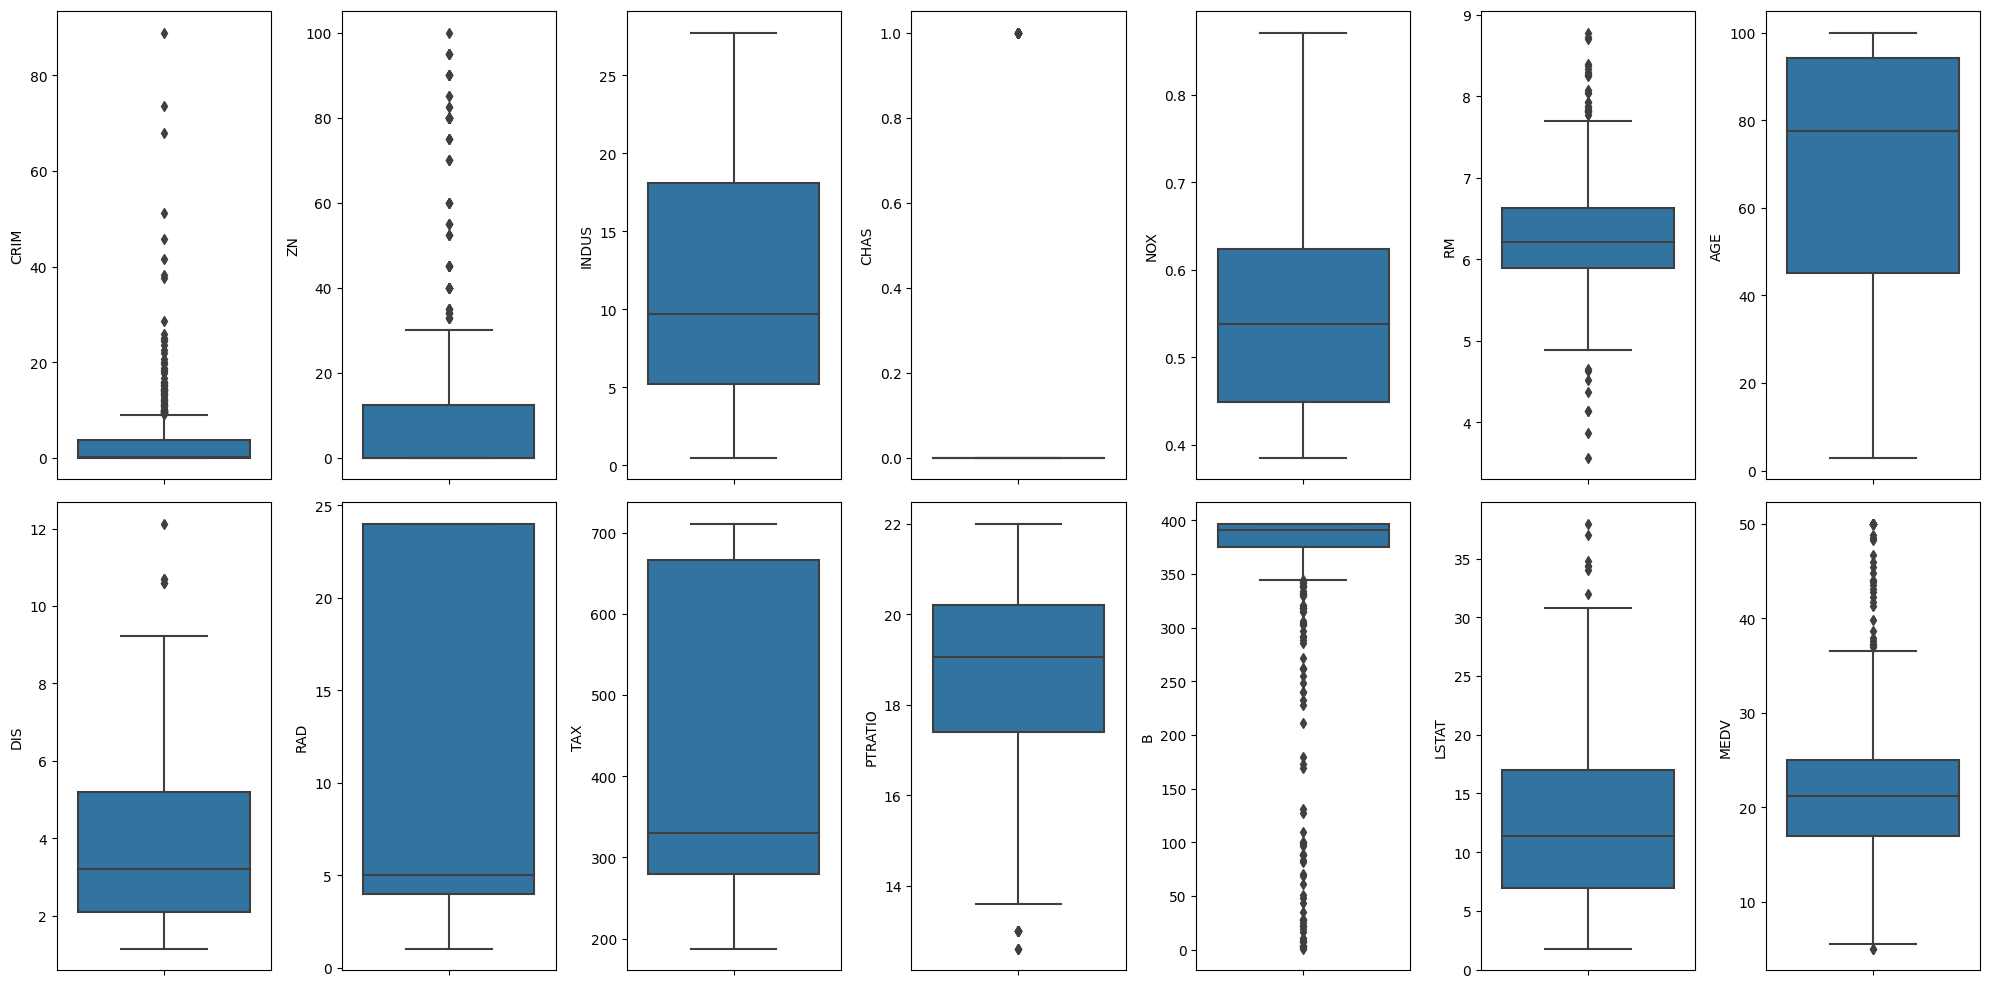

In [7]:
#Box Plot of every column in the data
fig, ax = plt.subplots(ncols = 7, nrows = 2, figsize = (20,10))
ax=ax.flatten()
index = 0
for i,j in df.items():
    sns.boxplot(y=i, data = df, ax=ax[index])
    index+=1
plt.tight_layout()


In [8]:
# Outliers count, percentage of outliers in each column
for i,j in df.items():
    q1 = j.quantile(0.25) # Lower quartile range
    q3 = j.quantile(0.75) # Upper quartile range
    iqr = q3-q1 # Interquartile range (IQR)
    # Outlier is defined as anything 1.5x the IQR from the lower or upper quartile range
    outliers = j[(j<=q1-1.5*iqr) | (j>=q3+1.5*iqr)]
    p = np.shape(outliers)[0] * 100/np.shape(df)[0]
    print(i,p)


CRIM 13.043478260869565
ZN 13.438735177865613
INDUS 0.0
CHAS 100.0
NOX 0.0
RM 5.928853754940712
AGE 0.0
DIS 0.9881422924901185
RAD 0.0
TAX 0.0
PTRATIO 2.964426877470356
B 15.217391304347826
LSTAT 1.383399209486166
MEDV 7.905138339920948


#### Conclusions:

##### - When deciding what to do with outliers we need to look at our ML model. Gradient Boosted Regression Trees use thresholding on input features for decisions. This makes them less sensitive to high leverage points and outliers within the input features. 
##### - However for the output feature, Regression Trees uses variance as its cost function which is calculated with a sum of squares. This means that large outliers will appear to have even larger residuals, which will disproportionately focus the model on these points. For this reason we need to get rid of the outliers on our target feature MEDV. 
##### - With all this in mind we also...   (Insert any other info on columns we discluded because of outliers here*)

#### Outlier Removal:

In [9]:
def outlier_removal(df, column: str):
    """Removes rows with outliers in a particular column

    Args:
        df (pandas DataFrame): The DataFrame we want the values removed from
        column (str): The column we're checking for outliers

    Returns:
        df (pandas DataFrame): The DataFrame minus the outliers
    """
    # Calculate IQR
    upper_QR = df[column].quantile(0.75)
    lower_QR = df[column].quantile(0.25)
    inter_QR = upper_QR-lower_QR
    # Filter for outliers
    df = df[df[column]<(upper_QR+(1.5*inter_QR))] # Gets all values below upper outlier limits
    df = df[df[column]>(lower_QR-(1.5*inter_QR))] # Gets all values above lower limits
    # Reset indexes 
    df.reset_index(drop=True)
    
    return df


In [10]:
# Remove Outliers
df = outlier_removal(df, "MEDV")
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 466 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     466 non-null    float64
 1   ZN       466 non-null    float64
 2   INDUS    466 non-null    float64
 3   CHAS     466 non-null    int64  
 4   NOX      466 non-null    float64
 5   RM       466 non-null    float64
 6   AGE      466 non-null    float64
 7   DIS      466 non-null    float64
 8   RAD      466 non-null    int64  
 9   TAX      466 non-null    float64
 10  PTRATIO  466 non-null    float64
 11  B        466 non-null    float64
 12  LSTAT    466 non-null    float64
 13  MEDV     466 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 54.6 KB
None


#### Summary: 

##### Summarize all conclusions and justifications drawn from EDA here

# Task 1: Gradient Boosted Tree Regression with sklearn 

#### Introduction to task, high level definition on what graident boosted trees are

#### Introduction to sklearn's model and its components (Decision Trees), hyperparameters we needed to consider, and any other coding specific additions we kept in mind.

#### The code below will take you through our implementation with sklearn.  

In [11]:
# Split Data into our inputs (X) and output (y) with only our selected features
X = df[['LSTAT', 'RM', 'TAX', 'PTRATIO', 'CRIM', 'NOX']]
y = df['MEDV']

# Split data further into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=12)

# Create our model
model = GradientBoostingRegressor()
# Implement GridSearchCV to optimize hyper-parameters
params = {'min_samples_leaf':[5,10,15,20,25,30], 'max_depth':[2,3,4,5,6,7,8,9,10]} # Params for it to cycle through
clf = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring= 'r2')
# Fit model
clf.fit(X_train, y_train)
# Make predictions
y_pred = clf.predict(X_test)
# Print model performance metrics
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
print(clf.best_params_)


MSE: 5.71460773788788
MAE: 1.9002305070821948
R2: 0.8780490966447156
{'max_depth': 3, 'min_samples_leaf': 15}


#### Summary:

##### Summarize and justify our approach and findings (why we chose those values for hyperparameters, tuning process, etc)

# Task 2: Manually Implementing Gradient Boosted Tree Regression

##### Breakdown of our intial plan: Make a decision tree class, a gradient boosted class, and the other sklearn functions we needed. Include the breakdown across the team. 

### Custom Functions:

In [12]:
# Below are our version of the performance metric functions, and the train, test, split function

# Train, Test Split
def my_train_test_split(X: pd.DataFrame,y: pd.DataFrame, test_size: float = 0.2, random_state: int = None) -> pd.DataFrame:
    """Splits data into training and testing DataFrames

    Args:
        X (pd.DataFrame): Input DataFrame to be split
        y (pd.DataFrame): Output DataFrame to be split
        test_size (float, optional): Percentage of data in test DataFrame. 
            Defaults to 0.2.
        random_state (int, optional): Saves the split configuration for reusability. 
            Defaults to None.

    Returns:
        X_train, X_test, y_train, y_test (pd.DataFrame): Split DataFrames 
    """
    #get random seed to allow reproduceability
    random.seed(random_state)
    #select test indexes from range of total indexes
    test_ixs= random.sample(range(len(y)), math.floor(len(y)*test_size))
    #return X_train, X_test, y_train, y_test (train sets are total sets - test sets)
    return X.drop(test_ixs), X.iloc[test_ixs], y.drop(test_ixs), y.iloc[test_ixs]
    
# Performance Metric Functions: MSE, RMSE, MAE, R2
def my_mse(a: np.ndarray, b: np.ndarray) -> float:
    """Find Mean Square Error (MSE) between predicted and observed data.

    Args:
        a (np.ndarray): Observed Data
        b (np.ndarray): Predicted Data

    Returns:
        mse (float): The final MSE
    """
    return np.mean((a-b)**2)

def my_rmse(a: np.ndarray, b: np.ndarray) -> float:
    """Finds root mean square error (RMSE) between predicted and observered data.

    Args:
        a (np.ndarray): Observed Data
        b (np.ndarray): Predicted Data

    Returns:
        math.sqrt(MSE) (float): Final root mean square error (RMSE) in eq format.
    """
    return math.sqrt(my_mse(a,b))

def my_mae(a: np.ndarray,b: np.ndarray) -> float:
    """Finds mean absolute error (MAE) between predicted and observed data.

    Args:
        a (np.ndarray): Observed Data
        b (np.ndarray): Predicted Data

    Returns:
        mae (float): Final mean absolute error (MAE)
    """
    return np.mean(np.abs(a-b))

def my_r2(a: np.ndarray,b: np.ndarray) -> float:
    """Finds R2 (Coeff of Determination) score between predicted and observed data

    Args:
        a (np.ndarray): Observed Data
        b (np.ndarray): Predicted Data

    Returns:
        r2 (float): The final R2 score (in eq format)
    """
    y_bar = sum(a)/len(a)
    ss_res = np.mean((a-b)**2)
    ss_tot = np.mean((a-y_bar)**2)
    return 1-(ss_res/ss_tot)

def my_performance(a: pd.DataFrame, b: pd.DataFrame):
    """Turns predicted and observed data to numpy ndarrays and carries out MSE, RMSE, MAE, and R2

    Args:
        a (pd.DataFrame): Observed Data
        b (pd.DataFrame): Predicted Data
    """
    if not isinstance(a, np.ndarray):
        a=a.to_numpy()
    if not isinstance(b, np.ndarray):
        b=b.to_numpy()
    print(f'Mean Squared Error: {my_mse(a,b)}')
    print(f'Root Mean Squared Error: {my_rmse(a,b)}')
    print(f'Mean Absolute Error: {my_mae(a,b)}')
    print(f'R2 Score: {my_r2(a,b)}')



### Custom Classes:

In [13]:
# Decision Tree Class: Used as a week learned within the gradient boosting ensemble

class DecisionTree:
    """A Decision Tree used for regression

    Instance Attributes:
        max_depth (int): Max amount of branches for a tree (Stopping Criteria)
        tree (DecisionTree.Node): Where tree will be saved, compilation of nodes and their branches
    """
    def __init__(self, max_depth: int =1):
        self.max_depth = max_depth
        self.tree = None

    class Node:
        """A node of a decision tree. 
        Each node is a decision point for traversing through the decision tree,
        or a leaf node for stopping transversal.

        Instance Attributes:
            feature_index (int): A number representing the column/feature we are thresholding on
            threshold (float): The value of our feature_index that a Decision Node splits on
            left (DecisionTree.Node): The next node that branches left from our current 
                decision node (<= Threshold)
            right (DecisionTree.Node): The next node that branches right from our current 
                decision node (> Threshold)
            value: Value that the decision tree predicts if a data point ends its tree transversal 
                at this leaf node (only leaf nodes have a value, and they only have a value)
        """
        def __init__(self, feature_index: int = None, threshold: float = None, left: 'DecisionTree.Node' = None, right: 'DecisionTree.Node' = None, value: float =None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Fits tree to the given data

        Args:
            X (np.ndarray): Input (feature) data you are fitting tree to
            y (np.ndarray): Output (observation) data you are fitting tree to
        """
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> 'DecisionTree.Node':
        """Builds our tree based on the given data through performing Recursive Binary Splitting

        Args:
            X (np.ndarray): Input (features) training data
            y (np.ndarray): Output (observations) training data 
            depth (int): Tracks depth of tree as tree is built through recursively calling

        Returns:
            Node (DecisionTree.Node): Returns decision or leaf node
        """
        # Gets number of rows (samples) and columns (features)
        num_samples, num_features = X.shape
        # Check Stopping Criteria
        if depth >= self.max_depth or num_samples <= 1:
            # If met it marks a leaf node, calculate value and create node
            leaf_value = self._calculate_leaf_value(y)
            return self.Node(value=leaf_value)

        # Find the best split
        best_feature, best_threshold = self._find_best_split(X, y, num_samples, num_features)
        # If no split can improve the outcome, create a leaf node
        if best_feature is None:
            return self.Node(value=self._calculate_leaf_value(y))

        # Split the dataset and recursively build left and right subtrees
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left_subtree = self._build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right_subtree = self._build_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return self.Node(feature_index=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

    def _calculate_leaf_value(self, y: np.ndarray) -> float:
        """Calculates the leaf value, which is the value instance attribute of the node class. 
        For a regression Decision Tree, this value is the mean of the output training data sorted 
        to this node.

        Args:
            y (np.ndarray): Output (observations) training data sorted to this leaf node.

        Returns:
            mean: Mean of the output training data sorted to this node. 
        """
        return np.mean(y)

    def _find_best_split(self, X: np.ndarray, y: np.ndarray, num_samples: int, num_features: int) -> int | float:
        """Finds the best feature and threshold to split on based 
        on the lowest mean square error (MSE).

        Args:
            X (np.ndarray): Input (features) training data sorted to this decision node.
            y (np.ndarray): Output (observations) training data sorted to this decision node
            num_samples (int): Number of rows in X
            num_features (int): Number of columns in X

        Returns:
            best_feature (int): The best feature for node to split on
            best_threshold (float): The best threshold of the best_feature for node to split on
        """
        # Initialize variables
        best_feature, best_threshold = None, None
        best_mse = np.inf
        # Loops through every feature (column) of X
        for feature_index in range(num_features):
            # Array of potential thresholds to split data on
            thresholds = np.unique(X[:, feature_index])
            # Calculate the MSE for the split of every potential threshold
            for threshold in thresholds:
                left_idxs, right_idxs = self._split(X[:, feature_index], threshold)
                if len(left_idxs) == 0 or len(right_idxs) == 0:
                    continue
                mse = self._calculate_mse(y[left_idxs], y[right_idxs])
                # Update split if current mse is better
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature_index
                    best_threshold = threshold
        return best_feature, best_threshold

    def _split(self, feature_values: int, threshold: float) -> np.ndarray:
        """Splits dataset into left_idxs/right_idxs based on threshold of a given feature

        Args:
            feature_values (_type_): The feature the dataset is split on
            threshold (float): Threshold/Value of the feature the dataset is split on

        Returns:
            left_idxs (type): Dataset split that are less than or equal to threshold 
                of chosen feature
            right_idxs (type): Dataset split that are more than threshold of chosen feature
        """
        left_idxs = np.where(feature_values <= threshold)[0]
        right_idxs = np.where(feature_values > threshold)[0]
        return left_idxs, right_idxs

    def _calculate_mse(self, left_y: np.ndarray, right_y: np.ndarray) -> float:
        """ Calculates the MSE of the left and right splits by the weighted variances

        Args:
            left_y (np.ndarray): Dataset split that are less than or equal to splitting condition
            right_y (np.ndarray): Dataset split that are more than splitting condition

        Returns:
            total_mse (float): The total weighted sum of the MSEs
        """
        total_left_mse = np.var(left_y) * len(left_y) if len(left_y) > 0 else 0
        total_right_mse = np.var(right_y) * len(right_y) if len(right_y) > 0 else 0
        total_mse = (total_left_mse + total_right_mse) / (len(left_y) + len(right_y))
        return total_mse

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Returns the Decision Trees prediction value for an array of data points 
        by looping over all points with the _transverse_tree method.

        Args:
            X (np.ndarray): Array of data points that we want predictions for

        Returns:
            predictions (np.ndarray): Array of predictions
        """
        # Predictions array to store predictions for each sample in X
        predictions = np.array([self._traverse_tree(x, self.tree) for x in X])
        return predictions

    def _traverse_tree(self, x: np.ndarray, node: 'DecisionTree.Node'):
        """Recursive method to transverse the tree for a single sample 'x' 
        until a leaf node is reached

        Args:
            x (np.ndarray): Single row/sample of data
            node (DecisionTree.Node): The node we're currently at on the tree

        Returns:
            Node.Value (float): The prediction for x
            self._transverse_tree (Function): Recursively calls itself to move on to next node
        """
        # Checks if node is a leaf node (only leaf nodes have a value attribute)
        if node.value is not None:
            return node.value
        # Navigates to next node based on current decision node's splitting condition
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [19]:
# Boosted Gradient Class
class GradientBoostAll:
    """Class for creating Gradient Boosted Regression Trees ML model

    Instance Attributes:
        max_depth (int): Max amount of branches for a tree (stops splitting once hit)
        n_estimators (int): The amount of trees (iterations) that will be gradient boosted
        learning_rate (float): The step size made each iteration to minimize the loss
        trees (list): A list of all the trees made during boosting
    """
    def __init__(self, n_estimators: int = 25, max_depth: int = 1, learning_rate: float =.1):
        self.max_depth = max_depth # Max depth of the trees
        self.n_estimators = n_estimators # Number of trees
        self.learning_rate = learning_rate # Learning rate, step size for parameter update
        self.trees = [] # List of our trees

    def fit(self, X_train: pd.DataFrame, y_train: pd.DataFrame):
        """Fits boosted trees to the given data

        Args:
            X_train (pd.DataFrame): Training input data
            y_train (pd.DataFrame): Training output (observed) data
        """
        # Transform args to numpy
        X_train = X_train.to_numpy()
        y_train = y_train.to_numpy()
        # Initialize variables: residuals = y_train to start
        residuals = np.copy(y_train)
        # Make n_estimator amount of decision tree
        for i in range(self.n_estimators):
            # Build and Fit Tree to data
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_train, residuals)
            # Save our tree
            self.trees.append(tree)
            # Make prediction
            f_hat = tree.predict(X_train)
            # Update residuals
            residuals = residuals - (self.learning_rate*f_hat)

    def predict(self, X_test: pd.DataFrame) -> np.ndarray:
        """Uses trained Gradient Boosted Tree model to make predictions on data

        Args:
            X_test (pd.DataFrame): Testing or actual data that predictions will be made on

        Returns:
            y_hat (np.ndarray): Predictions made by trained model
        """
        # Transform arg to numpy
        X_test = X_test.to_numpy()
        # Make sure class instance has been fit to data
        if not self.trees:
            raise ValueError("This instance of GradientBoostAll class hasn't been fit to data")
        # Initialize prediction to be same length as input data
        y_hat = np.zeros((X_test.shape[0], ))
        # Sum prediction from each tree
        for tree in self.trees:
            y_hat += self.learning_rate*tree.predict(X_test)
        return y_hat


In [20]:
# K-fold Cross Validation to Optimize Hyperparameters
def kfold_cv(X_train, y_train, K_folds = 5, random_state = None, n_estimators: int = 25, max_depth: int = 1, learning_rate: int =.1):
    # Create empty lists for r2 and MSE scores
    r2_list = []
    mse_list = []
    np.random.seed(random_state) # Set random state for reproduceability
    indices = np.arange(len(X_train)) # Create list of indices from array length
    np.random.shuffle(indices) # Randomly shuffle indices
    fold_size = math.floor(len(X_train)/K_folds) # Set fold size as length/K
    for i in range(K_folds-1):
        # Create start- and end-points based of ith fold based on fold size (last fold is larger unless K evenly divides length)
        start = i * fold_size
        end = (i + 1) * fold_size if i < K_folds - 1 else len(X_train)
        # Set test indices as those within range of start- and end-points, train indices as those outside range
        test_indices = indices[start:end] 
        train_indices = np.concatenate((indices[:start], indices[end:]))
        # Create new train and test sets from original X_train and y_train using train and test indices
        X_train_fold = X_train.iloc[train_indices]
        X_test_fold = X_train.iloc[test_indices]
        y_train_fold = y_train.iloc[train_indices]
        y_test_fold = y_train.iloc[test_indices]
        # Initalize gradient boosting model using parameters specified in function call
        model = GradientBoostAll(n_estimators= n_estimators, max_depth=max_depth, learning_rate=learning_rate)
        # Fit model on fold training data
        model.fit(X_train_fold, y_train_fold) 
        # Model makes predictions based on fold X_test
        y_pred_fold = model.predict(X_test_fold)
        # r2 score added to list
        r2_list.append(my_r2(y_test_fold, y_pred_fold))
        # MSE added to list
        mse_list.append(my_mse(y_test_fold, y_pred_fold))
    return np.mean(r2_list), np.mean(mse_list) # returns average r2 and MSE scores across all folds



In [21]:
kfold_cv(X_train, y_train)

(0.6194592366363394, 15.791434663676835)

In [22]:
def grid_search_kf(X_train, y_train, X_test, y_test, param_grid, random_seed=None, K_folds = 5):
    # Create best score metric (to be beaten) and best parameter dictionary
    best_score = float('inf')
    best_params = {}

    # For every combination of parameters in parameter grid, this will perform K-fold cross validation 
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                # Gets average r2, average MSE from k-fold cross validation on training data with this combination of hyperparameters
                r2, score = kfold_cv(X_train, y_train, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=random_seed, K_folds=K_folds)
                # If this MSE is better (lower) than the previous best, replace the existing best score and best parameters with these
                if score < best_score:
                    best_score = score
                    best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

    # Initialize gradient boosting model with best parameters
    model = GradientBoostAll(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], learning_rate=best_params['learning_rate'])
    # Fit model on training data
    model.fit(X_train, y_train)
    # Model makes prediction based on test data
    y_pred = model.predict(X_test)
    return my_performance(y_test, y_pred) # Return performance metrics checked against y_test

# Execute grid search
param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2, 0.5]
}

# Assuming X_train, y_train, X_test, and y_test are already defined
grid_search_kf(X_train, y_train, X_test, y_test, param_grid)

Mean Squared Error: 6.3043795087040895
Root Mean Squared Error: 2.510852347053504
Mean Absolute Error: 1.7633820890697622
R2 Score: 0.8494806207021945


### Testing the Implementation

In [15]:
# Split the dataset using our function
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
X_train, X_test, y_train, y_test = my_train_test_split(X,y,test_size=0.2, random_state=12)

# Gradient Boost Regression
our_model = GradientBoostAll(n_estimators= 100, max_depth=5)
# Fit the model
our_model.fit(X_train, y_train)
# Make the predictions
predictions = our_model.predict(X_test)
# Prints Model Metrics
my_performance(y_test, predictions)

Mean Squared Error: 6.214206321964261
Root Mean Squared Error: 2.492830985438897
Mean Absolute Error: 1.8137568628094065
R2 Score: 0.8516335386981123


### Analysis Between Task 2 and 3:

##### Want to analyze the two performance indicators (Go back and save the values from the performance model so we can call them here)

In [18]:
# Comparison 
def random_state_tester(rs_start = 0, rs_end = 10, sk_min_samples_leaf = 1, sk_max_depth = 3, our_max_depth = 3, our_learning_rate = 0.1, our_n_estimators = 100):
    # Initialize lists for sklearn's and our r2 and MSE scores
    sk_r2 = []
    our_r2 = []
    sk_mse = []
    our_mse = []
    for i in range(rs_start, rs_end): 
        # Perform train-test-split on specific random state (sklearn train-test-split used for reproduceability across machines)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        # sklearn model initalized with parameters to match function inputs 
        sk_model = GradientBoostingRegressor(min_samples_leaf= sk_min_samples_leaf, max_depth=sk_max_depth)
        sk_model.fit(X_train, y_train)  # sklearn model fit on training data
        sk_y_pred = sk_model.predict(X_test) # sklearn model predicts from X_test
        sk_r2.append(r2_score(y_test, sk_y_pred)) # sklearn r2 score added to list
        sk_mse.append(mean_squared_error(y_test, sk_y_pred)) # sklearn MSE score added to list
        # our model initalized with parameters to match function inputs
        our_model = GradientBoostAll(max_depth=our_max_depth, learning_rate=our_learning_rate, n_estimators=our_n_estimators)
        our_model.fit((X_train), (y_train)) #our model fit on training data
        our_y_pred = our_model.predict((X_test)) #our model predicts from X_test
        our_r2.append(my_r2((y_test), our_y_pred)) #our r2 score added to list
        our_mse.append(my_mse((y_test), our_y_pred)) #our MSE added to list
    print(f'sklearn r2: {np.mean(sk_r2)}') # sklearn model's average r2
    print(f'sklearn MSE: {np.mean(sk_mse)}') # sklearn model's average MSE
    print(f'our r2: {np.mean(our_r2)}') # our model's average r2
    print(f'our MSE: {np.mean(our_mse)}') # our model's average MSE


random_state_tester(0,25)

sklearn r2: 0.8242478883865034
sklearn MSE: 6.875039373986575
our r2: 0.8221374636448178
our MSE: 6.959123054091391


# Conclusion:

##### Overall results

##### Knowledge gained

##### Areas for improvement

##### Documentation, packacking, productionising code (ask Miri what this looks like, currently unsure, are we just linking to the github which has everything?)